In this article I'll talk about one Multi-Label Image Classification competition: https://www.kaggle.com/competitions/plant-pathology-2021-fgvc8

I began to deal with this dataset when the competition was already finished. And as I see in "Discussions" tab there were some changes in dataset. That could be a problem why I can't make same successful results as other members. But let's discuss current dataset.

First of all if you check amount of different classes (labels) you will get something like this:

In [1]:
import pandas as pd
df = pd.read_csv('source/train.csv')
df['labels'].str.split(' ').value_counts()

[scab]                                 4826
[healthy]                              4624
[frog_eye_leaf_spot]                   3181
[rust]                                 1860
[complex]                              1602
[powdery_mildew]                       1184
[scab, frog_eye_leaf_spot]              686
[scab, frog_eye_leaf_spot, complex]     200
[frog_eye_leaf_spot, complex]           165
[rust, frog_eye_leaf_spot]              120
[rust, complex]                          97
[powdery_mildew, complex]                87
Name: labels, dtype: int64

Imagine that we already have a Multi-Label Classification script that is capable to train a model. Let's launch it and get the model. And when we get the model we will use that model to predict labels the same training (+validation) dataset. In that case you'd probably say: "We will get ~100% prediction rate results because we already used this dataset to make training!". Yes, this is obvious. And by means of that we'll check whether everything is OK with model/dataset.

We are expecting to get very hisgh accuracy (90% +), but we'll get something like this:

**I used MobileNetV2 and source images resized to 600x400 px.**

Look at our results (most importand column is the last one "correct %"). The model `couldn't predict` most of labels. Why?! There are some reasons for that bad results. Let's check images properly. For example let's pick some with 'rust' label. Unfortunately, I'm not an agronomist and I can't determine plants diseases by photo. But I can compare few photos and say that diseases with same label are different:

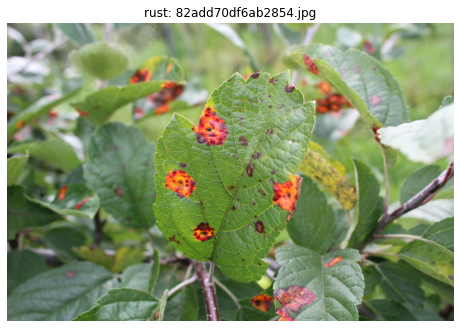

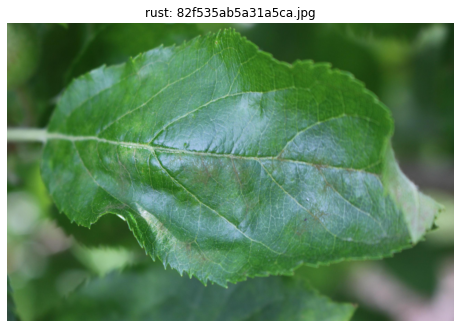

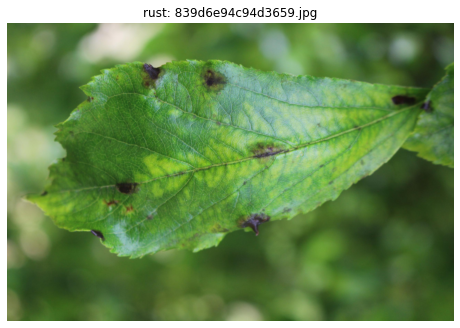

In [4]:
from tools_image import show_img

imgs = ['82f535ab5a31a5ca.jpg',
        '82add70df6ab2854.jpg',
        '839d6e94c94d3659.jpg']

da = df[df['labels'] == 'rust']
da = da[da['image'].isin(imgs)]

for index, row in da.iterrows():
    path, label = row
    show_img('source/train_images/' + path, f'{label}: {path}')

Take a look at that three different examples of 'rust'. As for me there are two infected/ill leafs. And one is quite healthy! Now we can see why our model cant predict 'rust' - because it can't understand what it is. And the worst thing that these examples of 'rust' makes impact on our model when we try to fit all labels semustaniously.

To solve that problem lets devide labels into groups to make a lot of models that can predict only few labels. For examples it could be pairs: "healthy - scab", "healthy - frog_eye_leaf_spot" etc. Every model will be able to separate healthy leafs and infected by only one disease.

As a dataset we'll use only pure data (not mixed), pure labels. I'll not do any augmentation. Let's think that 1000+ pics is enough for labels.

After models fitting we'll apply them to the same dataset as used for fitting (we already did something like that in the beginning of this article). And we'll get that results:

These 5 models can predict their illnesses with different probabilities. We can predict "frog_eye_leaf_spot" with 98% rate and in 83% cases can separate "healthy".

Now look at the bottom of this table. These two models are not capable to understand whether it is "powdery_mildew" or "healthy", "rust" or "healthy". It means that the dataset for "powdery_mildew" and "rust" is not clear (there is a "noise"). It contains combination of images (not only with "powdery_mildew" and "rust").

But we can make it clear by means of applying successful model to bad labels ("powdery_mildew" and "rust") and deleting images with recognized deseases. Whole process of data cleaning for "rust" dataset will look like that:

1. Use "frog_eye_leaf_spot / healthy' model to predict on "rust" label list.
2. Leave only "unknown" labels in the results (in tensorflow - [UNK] labels): delete all images with successfully detected "frog_eye_leaf_spot" or "healthy" labels.
3. Use dataset from stage 2 (with "unknown" images). Apply "scab / healthy" model to predict. Leave only "unknown" labels in the results: delete all images with successfully detected "scab" or "healthy" labels.
4. Use dataset from stage 3 (with "unknown" images). Apply "complex / healthy" model to predict. Leave only "unknown" labels in the results: delete all images with successfully detected "complex" or "healthy" labels.

Finnaly you'll get list of images that was not recognized by any other model. All of them have "unknown" label. It is really a (rust) disease that you are looking for. If you do that process properly then you will leave only ~20% of dataset of each: "rust" and "powdery_mildew". You will delete about 80% and the rest will be not enough to make a good fitting.

The second problem is that you have two "bad" labels. So "unknown" label contains "rust" OR/AND "powdery_mildew" (could be even mixed). And you can separate it only with "cross labels" data that we didn't use before:

Look at amount of that images. It's uncomparable with thousands images of pure classes....

And here I could make some good augmentation to increase that amount of images. But I decided not to make a kind of limited model that can predict only "frog_eye_leaf_spot", "complex", "scab", "healthy". And that model is quite successful:

At that point I stoped my attempts to make it better. Because as I said in the beggining of that article the competition is already finished. And there were changes in dataset. Probably I got data with mixed labels (other members use to talk about that in comments). Or my programming code contains a kind of mistakes... Anyway I'm done. Thank you for readnig! Hope you could get some interesting ideas from that article.

P.S.
I've programmed final model (that can predict 4 labels: "frog_eye_leaf_spot", "complex", "scab", "healthy") as RestAPI service (using Flask), and packed in docker container. You can find whole code on my GIT: 